# **🏠 부동산 실거래가 Baseline code**
> 부동산 실거래가 예측 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 RandomForest를 활용해 ML 방법론들을 실제 대회에 적용해보도록 하겠습니다.
> 강의는 google colab으로 실행하였기에 아래의 베이스라인 코드와는 일부 차이가 있을 수 있습니다. 

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Inference
- Output File Save


In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

import lightgbm as lgb

import joblib
import json

## 2. Data Load

#### 2.1. 데이터 로드

In [2]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = './data/train.csv'
test_path  = './data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [3]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [4]:
# Train과 Test data를 살펴보겠습니다.
display(dt.head(1))
display(dt_test.head(1))      # 부동산 실거래가(=Target) column이 제외된 모습입니다.

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,...,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0


In [5]:
def visualizeDistribution(df, feature_name, fsize=(10, 3), is_sort=False):
    count = df[feature_name].value_counts().sort_index()
    
    if is_sort == True:
        count = count.sort_values(ascending=False)

    # 거래 건수 시각화
    plt.figure(figsize=fsize)
    plt.bar(count.index.astype(str), count.values)
    plt.xlabel(feature_name)
    plt.ylabel(feature_name)
    plt.title(feature_name + '별 거래건수 분포')
    plt.xticks(rotation=45)

    feature_target = df.groupby(feature_name)['target'].mean()
    if is_sort == True:
        feature_target = feature_target.sort_values(ascending=False)

    plt.figure(figsize=fsize)

    plt.plot(feature_target.index.astype(str), feature_target.values, marker='o')
    plt.title(feature_name + '별 평균 시세 변화')
    plt.xlabel(feature_name)
    plt.ylabel('평균 시세')
    plt.xticks(rotation=45)
    
    plt.show()

def targetEncoding(df, feature_name):
    encoding_map = df[df['is_test'] == 0].groupby(feature_name)['target'].mean() # Target 데이터만 사용

    df.loc[df['is_test'] == 0, feature_name] = df.loc[df['is_test'] == 0, feature_name].map(encoding_map) # Train 데이터 target encoding
    df.loc[df['is_test'] == 1, feature_name] = df.loc[df['is_test'] == 1, feature_name].map(encoding_map) # Test 데이터 target encoding
    df.loc[df['is_test'] == 1, feature_name] = df.loc[df['is_test'] == 1, feature_name].fillna(df[df['is_test'] == 0]['target'].mean()) # Unseen 데이터 처리

    return encoding_map

## 3. Data Preprocessing

- 모델링 전에 데이터 내 결측치, 이상치 등을 제거하고 범주형과 연속형 변수를 살펴보도록 하겠습니다!
- 먼저, 용이한 전처리를 위해 train과 test data를 합친 하나의 데이터로 진행하도록 하겠습니다.

In [6]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [7]:
concat['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

0    1118822
1       9272
Name: is_test, dtype: int64

In [8]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

In [9]:
concat.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', 'is_test'],
      dtype='object')

In [10]:
concat.columns = concat.columns.str.replace(r'[^\w]', '_', regex=True) # for lightGBM

In [11]:
concat.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k_단지분류_아파트_주상복합등등_',
       'k_전화번호', 'k_팩스번호', '단지소개기존clob', 'k_세대타입_분양형태_', 'k_관리방식', 'k_복도유형',
       'k_난방방식', 'k_전체동수', 'k_전체세대수', 'k_건설사_시공사_', 'k_시행사', 'k_사용검사일_사용승인일',
       'k_연면적', 'k_주거전용면적', 'k_관리비부과면적', 'k_전용면적별세대현황_60_이하_',
       'k_전용면적별세대현황_60__85_이하_', 'k_85__135_이하', 'k_135_초과', 'k_홈페이지',
       'k_등록일자', 'k_수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타_의무_임대_임의_1_2_3_4', '단지승인일', '사용허가여부', '관리비_업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', 'is_test'],
      dtype='object')

### 3.1. 결측치 탐색 및 보간
- 결측치를 처리할 때 많이 쓰는 방법은 삭제(Deletion)과 대체(Imputation) 입니다.
- 본 Baseline에서는 결측치가 90% 이상을 차지하는 변수의 결측치는 제거하고, 나머지 결측치는 대체하도록 하겠습니다.
  - 연속형 변수의 경우에는 선형보간(Linear interpolation)으로 대체하겠습니다.
  - 범주형 변수의 경우에는 'NULL' 이라는 임의의 범주로 대체해주도록 하겠습니다.

- 참고 ✅
  - 선형보간(Linear interpolation)이란 두 점의 값이 주어졌을 때 **그 사이의 값**을 추정하기 위해 직선 거리에 따라 선형적으로 계산하는 방법입니다.
  - 아래 두개의 붉은 점 사이에 ($x$, $y$) 값을 추정하기 위해, 해당 점이 두 붉은 점을 이은 선형적인 선분에 있다고 가정하고, 단순 비례식으로 ($x$, $y$)를 추정해 보간하는 방법입니다.
  - [참고자료](https://ko.wikipedia.org/wiki/%EC%84%A0%ED%98%95_%EB%B3%B4%EA%B0%84%EB%B2%95#:~:text=%EC%84%A0%ED%98%95%20%EB%B3%B4%EA%B0%84%EB%B2%95(%E7%B7%9A%E5%9E%8B%E8%A3%9C%E9%96%93%E6%B3%95,%EC%9C%BC%EB%A1%9C%20%EA%B3%84%EC%82%B0%ED%95%98%EB%8A%94%20%EB%B0%A9%EB%B2%95%EC%9D%B4%EB%8B%A4.)


> 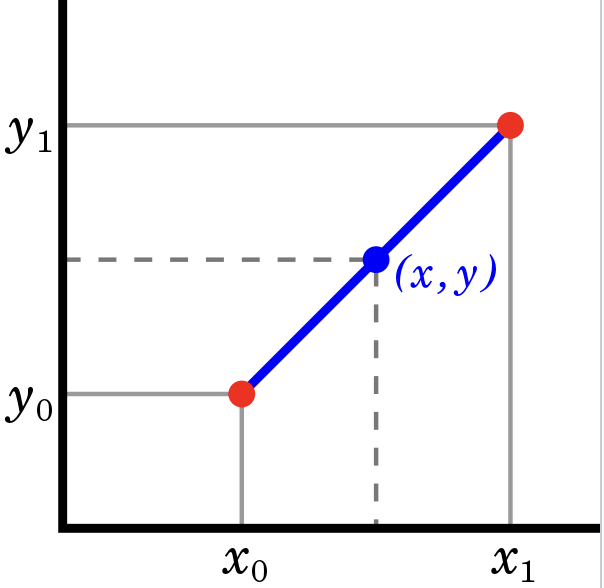

In [12]:
# 실제로 결측치라고 표시는 안되어있지만 아무 의미도 갖지 않는 element들이 아래와 같이 존재합니다.
# 아래 3가지의 경우 모두 아무 의미도 갖지 않는 element가 포함되어 있습니다.
display(concat['등기신청일자'].value_counts())

            1111271
20230630        585
20230831        496
20230428        394
20230731        374
             ...   
20230105          3
20230125          3
20230109          1
20230102          1
20230104          1
Name: 등기신청일자, Length: 182, dtype: int64

In [13]:
display(concat['거래유형'].value_counts())

-       1086451
중개거래      38123
직거래        3520
Name: 거래유형, dtype: int64

In [14]:
display(concat['중개사소재지'].value_counts())

-                    1090013
서울 노원구                  2627
서울 송파구                  2540
서울 강남구                  2508
서울 강동구                  2038
                      ...   
서울 강북구, 서울 양천구             1
경기 남양주시, 경기 성남수정구          1
서울 송파구, 인천 계양구             1
경기 연천군, 서울 송파구             1
서울 중랑구, 인천 부평구             1
Name: 중개사소재지, Length: 739, dtype: int64

In [15]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

In [16]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat.isnull().sum()

시군구                             0
번지                            227
본번                             75
부번                             75
아파트명                         2136
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1121899
등기신청일자                    1111271
거래유형                      1086451
중개사소재지                    1090013
k_단지분류_아파트_주상복합등등_         877273
k_전화번호                     876850
k_팩스번호                     879348
단지소개기존clob                1058958
k_세대타입_분양형태_               876125
k_관리방식                     876125
k_복도유형                     876454
k_난방방식                     876125
k_전체동수                     877207
k_전체세대수                    876125
k_건설사_시공사_                 877637
k_시행사                      877834
k_사용검사일_사용승인일              876259
k_연면적                      876125
k_주거전용면적      

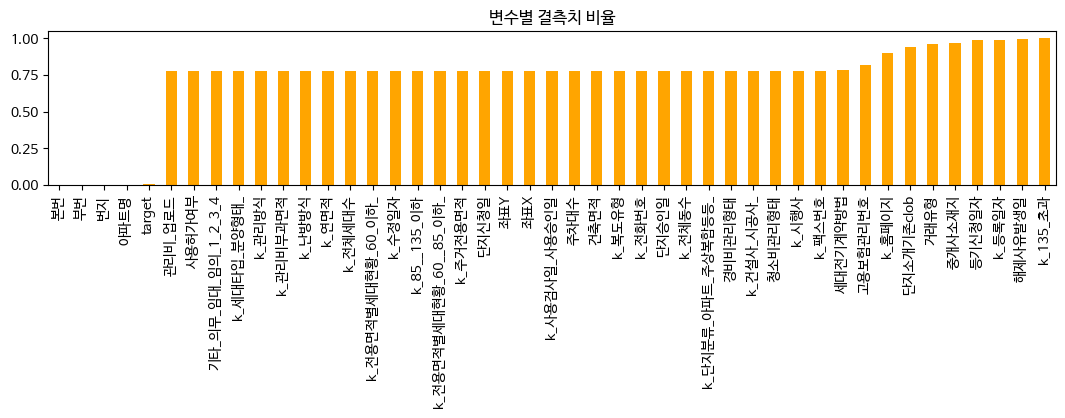

In [17]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

- 위 그래프에서 볼 수 있다시피 결측치가 100만개 이상인 칼럼들은 결측치가 해당 칼럼의 element 중 90% 이상을 차지하는 상황이 됩니다.
- 따라서 본 Baseline 에서는 이 칼럼은 예측에 도움이 되지 않는다고 판단해 삭제해주도록 하겠습니다.

In [18]:
# Null값이 100만개 이상인 칼럼은 삭제해보도록 하겠습니다.
print("* 결측치가 100만개 이하인 변수들 :", list(concat.columns[concat.isnull().sum() <= 1000000]))     # 남겨질 변수들은 아래와 같습니다.
print("* 결측치가 100만개 이상인 변수들 :", list(concat.columns[concat.isnull().sum() >= 1000000]))

* 결측치가 100만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'k_단지분류_아파트_주상복합등등_', 'k_전화번호', 'k_팩스번호', 'k_세대타입_분양형태_', 'k_관리방식', 'k_복도유형', 'k_난방방식', 'k_전체동수', 'k_전체세대수', 'k_건설사_시공사_', 'k_시행사', 'k_사용검사일_사용승인일', 'k_연면적', 'k_주거전용면적', 'k_관리비부과면적', 'k_전용면적별세대현황_60_이하_', 'k_전용면적별세대현황_60__85_이하_', 'k_85__135_이하', 'k_수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타_의무_임대_임의_1_2_3_4', '단지승인일', '사용허가여부', '관리비_업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test']
* 결측치가 100만개 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '단지소개기존clob', 'k_135_초과', 'k_홈페이지', 'k_등록일자']


In [19]:
# 위에서 결측치가 100만개 이하인 변수들만 골라 새로운 concat_select 객체로 저장해줍니다.
selected = list(concat.columns[concat.isnull().sum() <= 1000000])
concat_select = concat[selected]

In [20]:
concat_select.isnull().sum()     # 결측치가 100만개 초과인 칼럼이 제거된 모습은 아래와 같습니다.
# target변수는 test dataset 개수만큼(9272) 결측치가 존재함을 확인할 수 있습니다.

시군구                            0
번지                           227
본번                            75
부번                            75
아파트명                        2136
전용면적                           0
계약년월                           0
계약일                            0
층                              0
건축년도                           0
도로명                            0
k_단지분류_아파트_주상복합등등_        877273
k_전화번호                    876850
k_팩스번호                    879348
k_세대타입_분양형태_              876125
k_관리방식                    876125
k_복도유형                    876454
k_난방방식                    876125
k_전체동수                    877207
k_전체세대수                   876125
k_건설사_시공사_                877637
k_시행사                     877834
k_사용검사일_사용승인일             876259
k_연면적                     876125
k_주거전용면적                  876170
k_관리비부과면적                 876125
k_전용면적별세대현황_60_이하_        876170
k_전용면적별세대현황_60__85_이하_    876170
k_85__135_이하              876170
k_수정일자                    876170
고용보험관리번호  

In [21]:
# 연속형 변수는 선형보간을 해주고, 범주형변수는 알수없기에 “unknown”이라고 임의로 보간해 주겠습니다.
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 45 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1128094 non-null  object 
 1   번지                      1127867 non-null  object 
 2   본번                      1128019 non-null  float64
 3   부번                      1128019 non-null  float64
 4   아파트명                    1125958 non-null  object 
 5   전용면적                    1128094 non-null  float64
 6   계약년월                    1128094 non-null  int64  
 7   계약일                     1128094 non-null  int64  
 8   층                       1128094 non-null  int64  
 9   건축년도                    1128094 non-null  int64  
 10  도로명                     1128094 non-null  object 
 11  k_단지분류_아파트_주상복합등등_      250821 non-null   object 
 12  k_전화번호                  251244 non-null   object 
 13  k_팩스번호                  248746 non-null   object 
 14  k_세대타

In [22]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')

In [23]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'k_전체동수', 'k_전체세대수', 'k_연면적', 'k_주거전용면적', 'k_관리비부과면적', 'k_전용면적별세대현황_60_이하_', 'k_전용면적별세대현황_60__85_이하_', 'k_85__135_이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'is_test']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명', 'k_단지분류_아파트_주상복합등등_', 'k_전화번호', 'k_팩스번호', 'k_세대타입_분양형태_', 'k_관리방식', 'k_복도유형', 'k_난방방식', 'k_건설사_시공사_', 'k_시행사', 'k_사용검사일_사용승인일', 'k_수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타_의무_임대_임의_1_2_3_4', '단지승인일', '사용허가여부', '관리비_업로드', '단지신청일']


- 연속형 변수와 범주형 변수가 알맞게 나누어졌는지 확인해보고, 이제 각각 보간을 진행합니다.

In [24]:
# 범주형 변수에 대한 보간
concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat_select[continuous_columns] = concat_select[continuous_columns].interpolate(method='linear', axis=0)

In [25]:
concat_select.isnull().sum()         # 결측치가 보간된 모습을 확인해봅니다.

시군구                       0
번지                        0
본번                        0
부번                        0
아파트명                      0
전용면적                      0
계약년월                      0
계약일                       0
층                         0
건축년도                      0
도로명                       0
k_단지분류_아파트_주상복합등등_        0
k_전화번호                    0
k_팩스번호                    0
k_세대타입_분양형태_              0
k_관리방식                    0
k_복도유형                    0
k_난방방식                    0
k_전체동수                    0
k_전체세대수                   0
k_건설사_시공사_                0
k_시행사                     0
k_사용검사일_사용승인일             0
k_연면적                     0
k_주거전용면적                  0
k_관리비부과면적                 0
k_전용면적별세대현황_60_이하_        0
k_전용면적별세대현황_60__85_이하_    0
k_85__135_이하              0
k_수정일자                    0
고용보험관리번호                  0
경비비관리형태                   0
세대전기계약방법                  0
청소비관리형태                   0
건축면적                      0
주차대수                

- Baseline에서는 단순 결측치들을 제거하거나 보간했지만,
EDA를 통해 변수들의 흐름을 조금 더 파악하고 더 나은 interpolation 등의 방법을 고려해볼 수 있을 것 같습니다.

### 3.2. 이상치 처리
- 이번엔 이상치를 처리해봅시다.
- 이상치를 처리하는 방법은 IQR, Z-score 등 다양한 방법이 있습니다. 가장 쉽고 직관적으로 접근하는 방법은 기본 통계치를 이용하는 것입니다.
- 본 baseline에서는 IQR를 이용한 방법을 사용하겠습니다.

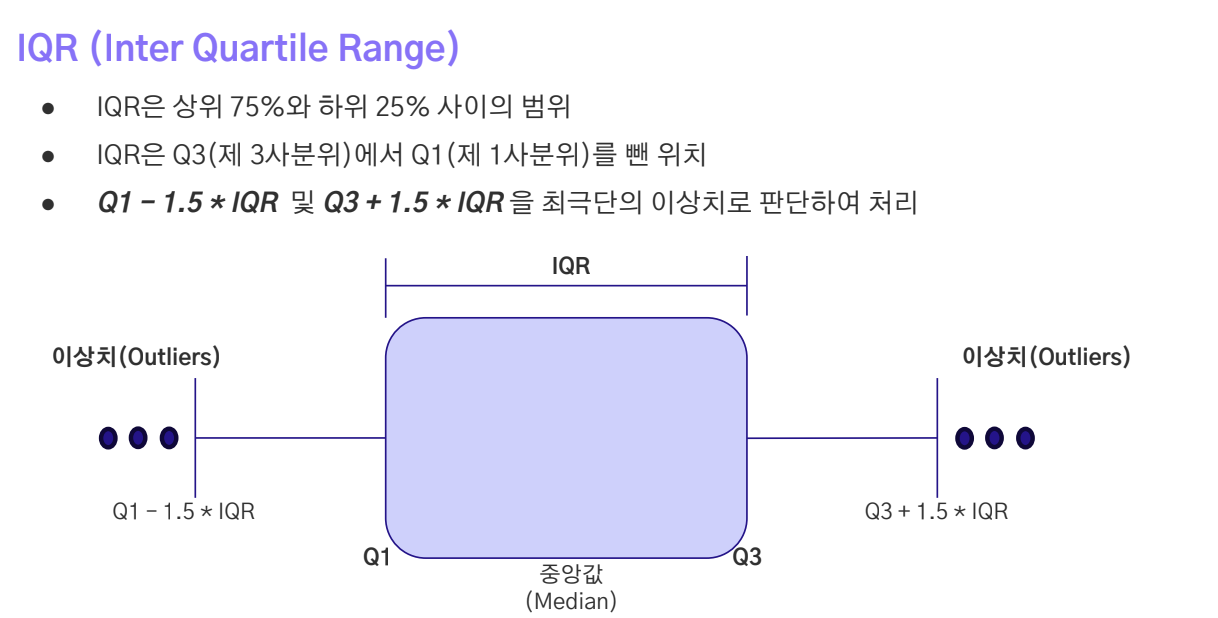

In [26]:
# 이상치 제거 이전의 shape은 아래와 같습니다.
print(concat_select.shape)

(1128094, 45)


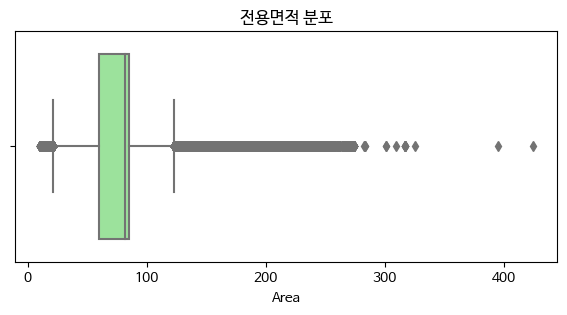

In [27]:
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat_select, x = "전용면적", color="lightgreen")
plt.title("전용면적 분포")
plt.xlabel("Area")
plt.show()

In [28]:
# 이상치 제거 방법에는 IQR을 이용하겠습니다.
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
    return result

In [29]:
# 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
concat_select = remove_outliers_iqr(concat_select, '전용면적')

In [30]:
# 이상치 제거 후의 shape은 아래와 같습니다. 약 10만개의 데이터가 제거된 모습을 확인할 수 있습니다.
print(concat_select.shape)

(1038846, 45)


In [31]:
concat_select['is_test'].value_counts()     # 또한, train data만 제거되었습니다.

0    1029574
1       9272
Name: is_test, dtype: int64

## 4. Feature Engineering
- 이제 파생변수를 만들어보도록 하겠습니다.
- 파생 변수는 도메인 지식에 기반해 제작하는 것이 중요합니다.
- 주택의 가격을 예측하는 문제이기 때문에 약간의 부동산 지식을 기반으로 파생 변수를 만들어 보도록 하겠습니다.

In [32]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat_select['구'] = concat_select['시군구'].map(lambda x : x.split()[1])
concat_select['동'] = concat_select['시군구'].map(lambda x : x.split()[2])
del concat_select['시군구']

concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])
del concat_select['계약년월']

In [33]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       'k_단지분류_아파트_주상복합등등_', 'k_전화번호', 'k_팩스번호', 'k_세대타입_분양형태_', 'k_관리방식',
       'k_복도유형', 'k_난방방식', 'k_전체동수', 'k_전체세대수', 'k_건설사_시공사_', 'k_시행사',
       'k_사용검사일_사용승인일', 'k_연면적', 'k_주거전용면적', 'k_관리비부과면적', 'k_전용면적별세대현황_60_이하_',
       'k_전용면적별세대현황_60__85_이하_', 'k_85__135_이하', 'k_수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타_의무_임대_임의_1_2_3_4',
       '단지승인일', '사용허가여부', '관리비_업로드', '좌표X', '좌표Y', '단지신청일', 'target',
       'is_test', '구', '동', '계약년', '계약월'],
      dtype='object')

- 서울의 집값은 강남, 강북 여부에 따라 차이가 많이 난다는 사실은 많이 알려진 사실입니다.
- 따라서 강남/강북의 여부에 따라 파생변수를 생성해주도록 하겠습니다.

In [34]:
# all = list(concat_select['구'].unique())
# gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
# gangbuk = [x for x in all if x not in gangnam]

# assert len(all) == len(gangnam) + len(gangbuk)       # 알맞게 분리되었는지 체크합니다.

In [35]:
# # 강남의 여부를 체크합니다.
# is_gangnam = []
# for x in concat_select['구'].tolist() :
#   if x in gangnam :
#     is_gangnam.append(1)
#   else :
#     is_gangnam.append(0)

# # 파생변수를 하나 만릅니다.
# concat_select['강남여부'] = is_gangnam

In [36]:
concat_select['구'].unique().tolist()[:5]

['강남구', '강동구', '강북구', '강서구', '관악구']

In [37]:
gu_encoding_map = targetEncoding(concat_select, '구')

In [38]:
concat_select['구'].value_counts().head(10)

33363.841554    113401
78407.547722     66541
42872.566566     63098
54419.286508     59223
96647.892035     57721
38268.124699     55207
44570.239693     55180
31093.771007     51105
54764.699305     50977
52689.669884     42215
Name: 구, dtype: int64

In [39]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       'k_단지분류_아파트_주상복합등등_', 'k_전화번호', 'k_팩스번호', 'k_세대타입_분양형태_', 'k_관리방식',
       'k_복도유형', 'k_난방방식', 'k_전체동수', 'k_전체세대수', 'k_건설사_시공사_', 'k_시행사',
       'k_사용검사일_사용승인일', 'k_연면적', 'k_주거전용면적', 'k_관리비부과면적', 'k_전용면적별세대현황_60_이하_',
       'k_전용면적별세대현황_60__85_이하_', 'k_85__135_이하', 'k_수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타_의무_임대_임의_1_2_3_4',
       '단지승인일', '사용허가여부', '관리비_업로드', '좌표X', '좌표Y', '단지신청일', 'target',
       'is_test', '구', '동', '계약년', '계약월'],
      dtype='object')

In [40]:
type(concat_select['구'].unique().tolist()[0])

float

- 또한 신축인지, 구축인지의 여부도 실거래가에 큰 영향을 줄 수 있습니다.
- 따라서 건축년도에 따라 파생변수를 제작해주도록 하겠습니다.

In [41]:
# 건축년도 분포는 아래와 같습니다. 특히 2005년이 Q3에 해당합니다.
# 2009년 이후에 지어진 건물은 10%정도 되는 것을 확인할 수 있습니다.
concat_select['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

count    1.038846e+06
mean     1.998583e+03
std      9.132471e+00
min      1.961000e+03
10%      1.987000e+03
25%      1.992000e+03
50%      2.000000e+03
75%      2.005000e+03
80%      2.006000e+03
90%      2.009000e+03
max      2.023000e+03
Name: 건축년도, dtype: float64

In [42]:
# 따라서 2009년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)

In [43]:
concat_select.head(1)       # 최종 데이터셋은 아래와 같습니다.

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,k_단지분류_아파트_주상복합등등_,...,좌표X,좌표Y,단지신청일,target,is_test,구,동,계약년,계약월,신축여부
0,658-1,658.0,1.0,개포6차우성,79.97,8,3,1987,언주로 3,아파트,...,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0,96647.892035,개포동,2017,12,0


In [44]:
concat_select.shape

(1038846, 48)

- 위 두 사항 외에도 외부 공공 데이터를 이용하거나, EDA를 통해 더 많은 변수를 제작할 수 있습니다.

## 5. Model Training

- 이제 위에서 만든 파생변수들과 정제한 데이터를 기반으로 본격적으로 부동산 실거래가를 예측하는 모델링을 진행하겠습니다.
- 모델링에는 `sklearn`의 `RandomForest`를 이용하도록 하겠습니다.

- 참고 ✅
  - `RandomForest`는 배깅(Bagging)의 일종으로, 학습시키는 데이터 뿐 아니라 특성변수(X)들도 무작위로 선택해 트리를 생성하는 방법입니다.
  - 모델 학습 과정에서 서로 다른 N개의 Tree 생성하고, N개의 Tree에서 발생한 Output을 Voting(범주형, 분류문제)하거나, Average(연속형, 회귀문제)해 최종 Output 생성합니다.
  - 이는 High variance, Low bias 상황에서 분산(Variance) 감소에 도움을 줍니다.

In [45]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1029574, 47) (9272, 47)


In [46]:
dt_test.head(1)

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,k_단지분류_아파트_주상복합등등_,...,관리비_업로드,좌표X,좌표Y,단지신청일,target,구,동,계약년,계약월,신축여부
0,658-1,658.0,1.0,개포6차우성,79.97,26,5,1987,언주로 3,아파트,...,N,127.05721,37.476763,2022-11-17 10:19:06.0,13250.0,96647.892035,개포동,2023,07,0


In [47]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

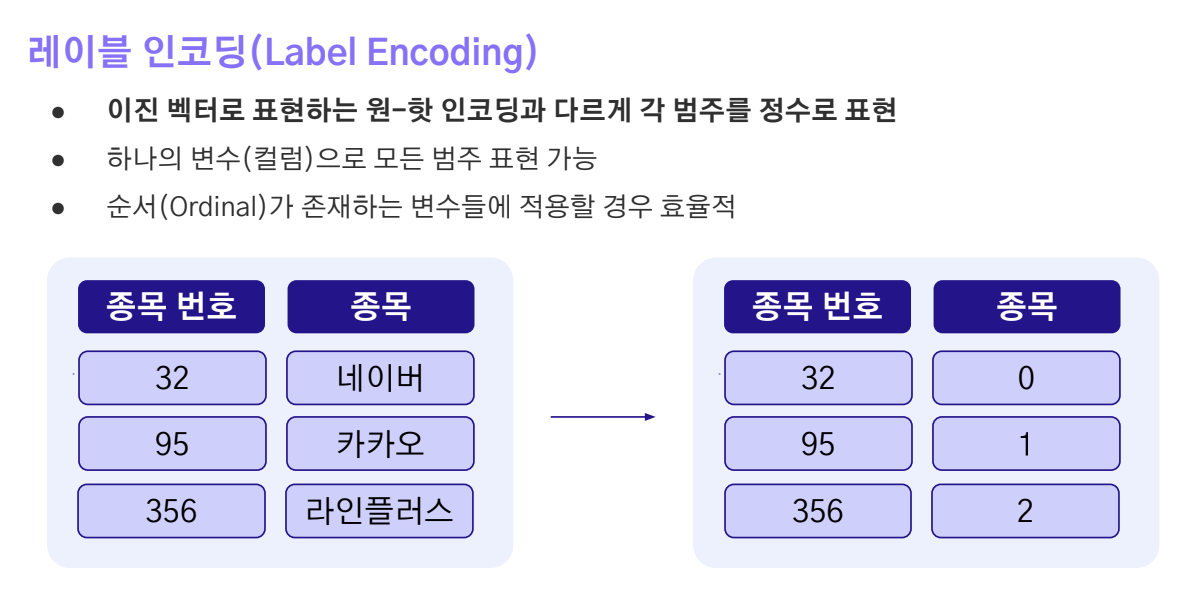

In [48]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    # if column == '구':
    #     continuous_columns_v2.append(column)
    #     continue
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', 'k_전체동수', 'k_전체세대수', 'k_연면적', 'k_주거전용면적', 'k_관리비부과면적', 'k_전용면적별세대현황_60_이하_', 'k_전용면적별세대현황_60__85_이하_', 'k_85__135_이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', '신축여부']
범주형 변수: ['번지', '본번', '부번', '아파트명', '도로명', 'k_단지분류_아파트_주상복합등등_', 'k_전화번호', 'k_팩스번호', 'k_세대타입_분양형태_', 'k_관리방식', 'k_복도유형', 'k_난방방식', 'k_건설사_시공사_', 'k_시행사', 'k_사용검사일_사용승인일', 'k_수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타_의무_임대_임의_1_2_3_4', '단지승인일', '사용허가여부', '관리비_업로드', '단지신청일', '구', '동', '계약년', '계약월']


In [49]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:08<00:00,  3.39it/s]


In [50]:
dt_train.head(1)        # 레이블인코딩이 된 모습입니다.

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,k_단지분류_아파트_주상복합등등_,...,관리비_업로드,좌표X,좌표Y,단지신청일,target,구,동,계약년,계약월,신축여부
0,4282,1114,1,293,79.97,8,3,1987,5520,3,...,0,127.05721,37.476763,240,124000.0,23,8,10,11,0


### 5.2. Model Training
- 위 데이터를 이용해 모델을 train 해보겠습니다. 모델은 RandomForest를 이용하겠습니다.
- Train과 Valid dataset을 분할하는 과정에서는 `holdout` 방법을 사용하겠습니다. 이 방법의 경우  대략적인 성능을 빠르게 확인할 수 있다는 점에서 baseline에서 사용해보도록 하겠습니다.
  - 이 후 추가적인 eda를 통해서 평가세트와 경향을 맞추거나 kfold와 같은 분포에 대한 고려를 추가할 수 있습니다.

In [51]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [52]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       'k_단지분류_아파트_주상복합등등_', 'k_전화번호', 'k_팩스번호', 'k_세대타입_분양형태_', 'k_관리방식',
       'k_복도유형', 'k_난방방식', 'k_전체동수', 'k_전체세대수', 'k_건설사_시공사_', 'k_시행사',
       'k_사용검사일_사용승인일', 'k_연면적', 'k_주거전용면적', 'k_관리비부과면적', 'k_전용면적별세대현황_60_이하_',
       'k_전용면적별세대현황_60__85_이하_', 'k_85__135_이하', 'k_수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타_의무_임대_임의_1_2_3_4',
       '단지승인일', '사용허가여부', '관리비_업로드', '좌표X', '좌표Y', '단지신청일', 'target',
       'is_test', '구', '동', '계약년', '계약월', '신축여부'],
      dtype='object')

In [53]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

## K-Fold

In [54]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(x, y, cv, ax, split_strategy='KFold', group=None, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    for ii, (tr, tt) in enumerate(cv.split(X=x, y=y, groups=group)):
        # Fill in indices with the training/test groups
        print(f"Fold {ii} :")
        print(f"  Train : index={tr[:5]}...")
        print(f"  Valid : index={tt[:5]}...")
        indices = np.array([np.nan] * len(x))
        indices[tt] = 1
        indices[tr] = 0
        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=0.2,
        )

    # Formatting
    yticklabels = list(range(5))

    ax.set(
        yticks=np.arange(len(yticklabels)) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[len(yticklabels) + 0.2, -0.2],
        xlim=[0, len(x)],
    )
    ax.set_title(split_strategy, fontsize=15)
    return ax

In [55]:
kf = KFold(n_splits=5)

Fold 0 :
  Train : index=[205915 205916 205917 205918 205919]...
  Valid : index=[0 1 2 3 4]...
Fold 1 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[205915 205916 205917 205918 205919]...
Fold 2 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[411830 411831 411832 411833 411834]...
Fold 3 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[617745 617746 617747 617748 617749]...
Fold 4 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[823660 823661 823662 823663 823664]...


<Axes: title={'center': 'K-Fold'}, xlabel='Sample index', ylabel='CV iteration'>

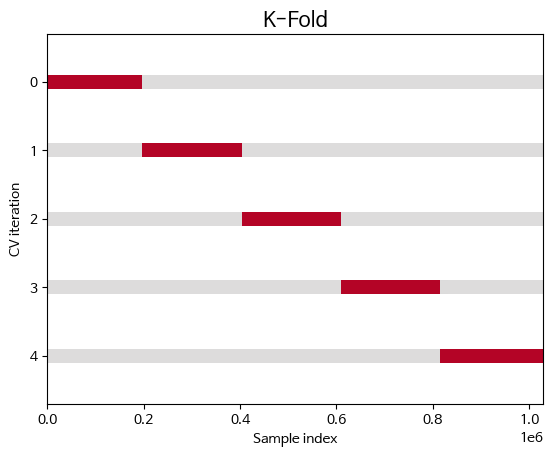

In [56]:
fig, ax = plt.subplots()
plot_cv_indices(x=X_train, y=y_train, cv=kf, ax=ax, split_strategy='K-Fold')

In [57]:
train_folds = kf.split(X_train, y_train)
display(train_folds)

<generator object _BaseKFold.split at 0x7f862d945770>

In [58]:
%%time
fold_save_files = []

for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    print(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    X_train_fold = X_train.iloc[train_idx, :]
    Y_train_fold = y_train.iloc[train_idx]

    X_valid_fold = X_train.iloc[valid_idx, :]
    Y_valid_fold = y_train.iloc[valid_idx]

    gbm = lgb.LGBMRegressor(n_estimators=100000,
                        metric='rmse',
                        data_sample_strategy='goss',
                        max_depth=12,
                        num_leaves=62,
                        min_data_in_leaf=40)
    gbm.fit(X_train_fold, Y_train_fold,
        eval_set=[(X_train_fold, Y_train_fold), (X_valid_fold, Y_valid_fold)],
        eval_metric = 'rmse',
        categorical_feature="auto",
        callbacks = [lgb.early_stopping(stopping_rounds=50),
                    lgb.log_evaluation(period=10, show_stdv=True)
        ]
    )

    file_name = f'kfold{fold_idx}_gbm.pkl'
    joblib.dump(gbm, file_name)
    fold_save_files.append(file_name)

--------0번째 fold의 학습을 시작합니다.--------
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6985
[LightGBM] [Info] Number of data points in the train set: 823659, number of used features: 46
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Info] Start training from score 52373.597513
Training until validation scores don't improve for 50 rounds
[10]	training's rmse: 18879	valid_1's rmse: 21095.5
[20]	training's rmse: 13580.3	valid_1's r

In [54]:
# # RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.
# model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
# model.fit(X_train, y_train)
# pred = model.predict(X_val)

In [ ]:
# %%time
# gbm = lgb.LGBMRegressor(n_estimators=100000,
#                         metric='rmse',
#                         data_sample_strategy='goss',
#                         max_depth=12,
#                         num_leaves=62,
#                         min_data_in_leaf=40)
# gbm.fit(X_train, y_train,
#         eval_set = [(X_train, y_train), (X_val, y_val)],
#         eval_metric = 'rmse',
#         categorical_feature="auto",
#         callbacks = [lgb.early_stopping(stopping_rounds=50),
#                     lgb.log_evaluation(period=10, show_stdv=True)
#         ] # early stopping 적용
# )

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7008
[LightGBM] [Info] Number of data points in the train set: 823659, number of used features: 46
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Info] Start training from score 53212.591237
Training until validation scores don't improve for 50 rounds
[10]	training's rmse: 19334.3	valid_1's rmse: 19297.5
[20]	training's rmse: 14059	valid_1's rmse: 14046.5
[30]	training's rmse: 11

LGBMRegressor(data_sample_strategy='goss', max_depth=12, metric='rmse',
              min_data_in_leaf=40, n_estimators=100000, num_leaves=62)

In [56]:
joblib.dump(gbm, 'tuning_lightgbm_sklearn_api.pkl')

['tuning_lightgbm_sklearn_api.pkl']

In [57]:
gbm_trained = joblib.load('tuning_lightgbm_sklearn_api.pkl')

- 랜덤포레스트의 하이퍼파라미터도 데이터에 맞게 지정해줄 수 있습니다. 데이터에 맞는 하이퍼파라미터를 찾는 것도 성능 향상에 도움이 될 수 있습니다.

In [58]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
pred = gbm_trained.predict(X_val)
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
RMSE test: 4176.446085374232


In [59]:
%%time
RMSE = mean_squared_error(y_val, pred) ** 0.5
print(f'추론 결과 rmse : {RMSE}')

추론 결과 rmse : 4176.446085374232
CPU times: user 14.8 ms, sys: 46 μs, total: 14.8 ms
Wall time: 1.35 ms


In [60]:
gbm_params = gbm_trained.get_params()
print(json.dumps(gbm_params, indent=4))

{
    "boosting_type": "gbdt",
    "class_weight": null,
    "colsample_bytree": 1.0,
    "importance_type": "split",
    "learning_rate": 0.1,
    "max_depth": 12,
    "min_child_samples": 20,
    "min_child_weight": 0.001,
    "min_split_gain": 0.0,
    "n_estimators": 100000,
    "n_jobs": null,
    "num_leaves": 62,
    "objective": null,
    "random_state": null,
    "reg_alpha": 0.0,
    "reg_lambda": 0.0,
    "subsample": 1.0,
    "subsample_for_bin": 200000,
    "subsample_freq": 0,
    "metric": "rmse",
    "data_sample_strategy": "goss",
    "min_data_in_leaf": 40
}


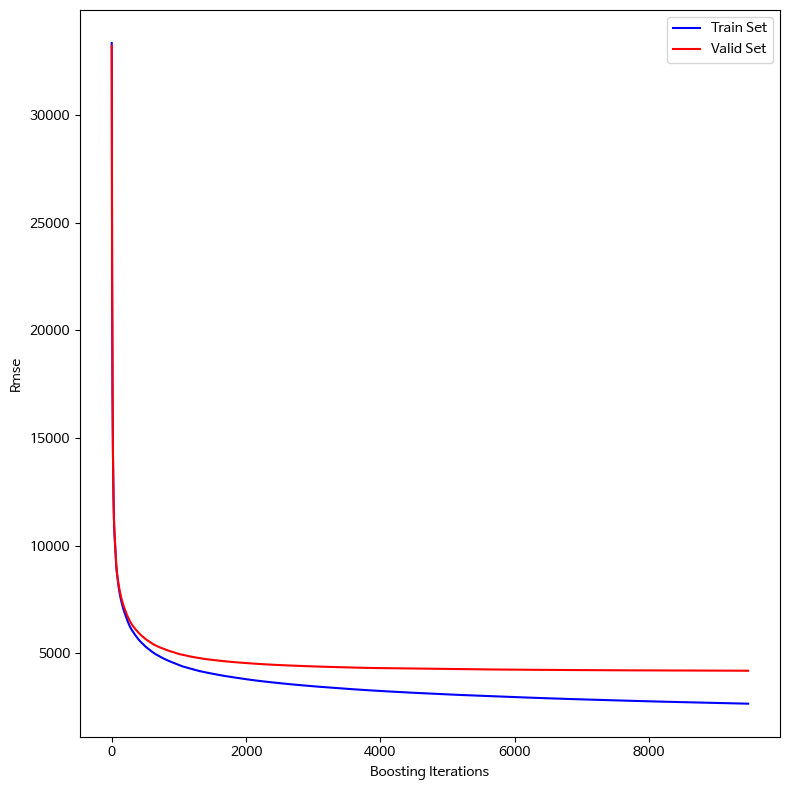

In [61]:
fig = plt.figure(figsize=(8, 8))
plt.subplot(1, 1, 1)
plt.plot(np.arange(len(list(gbm_trained.evals_result_['training']['rmse']))), list(gbm_trained.evals_result_['training']['rmse']), 
         'b-', label='Train Set')
plt.plot(np.arange(len(list(gbm_trained.evals_result_['training']['rmse']))), list(gbm_trained.evals_result_['valid_1']['rmse']), 'r-',
         label='Valid Set')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Rmse')
fig.tight_layout()
plt.show()

### 계약년별 valid set rmse

In [62]:
# 계약년별로 val set에 대한 rmse계산
val_feature_name = "계약년"
code_li = list(X_val[val_feature_name].unique())

valid_rmse_li = []
for code in code_li:
    valid_sets = X_val.loc[X_val[val_feature_name] == code]
    
    valid_predicts = gbm_trained.predict(valid_sets, verbosity=1)

    valid_rmse_li.append(mean_squared_error(y_val[valid_sets.index],valid_predicts) ** 0.5)

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min

In [63]:
# 계약년별 rmse결과를 오름차순 정렬
valid_rmse_df = pd.DataFrame({'code': code_li, 'rmse': valid_rmse_li})
valid_rmse_df = valid_rmse_df.sort_values(by='rmse', ascending=True).reset_index(drop=True)


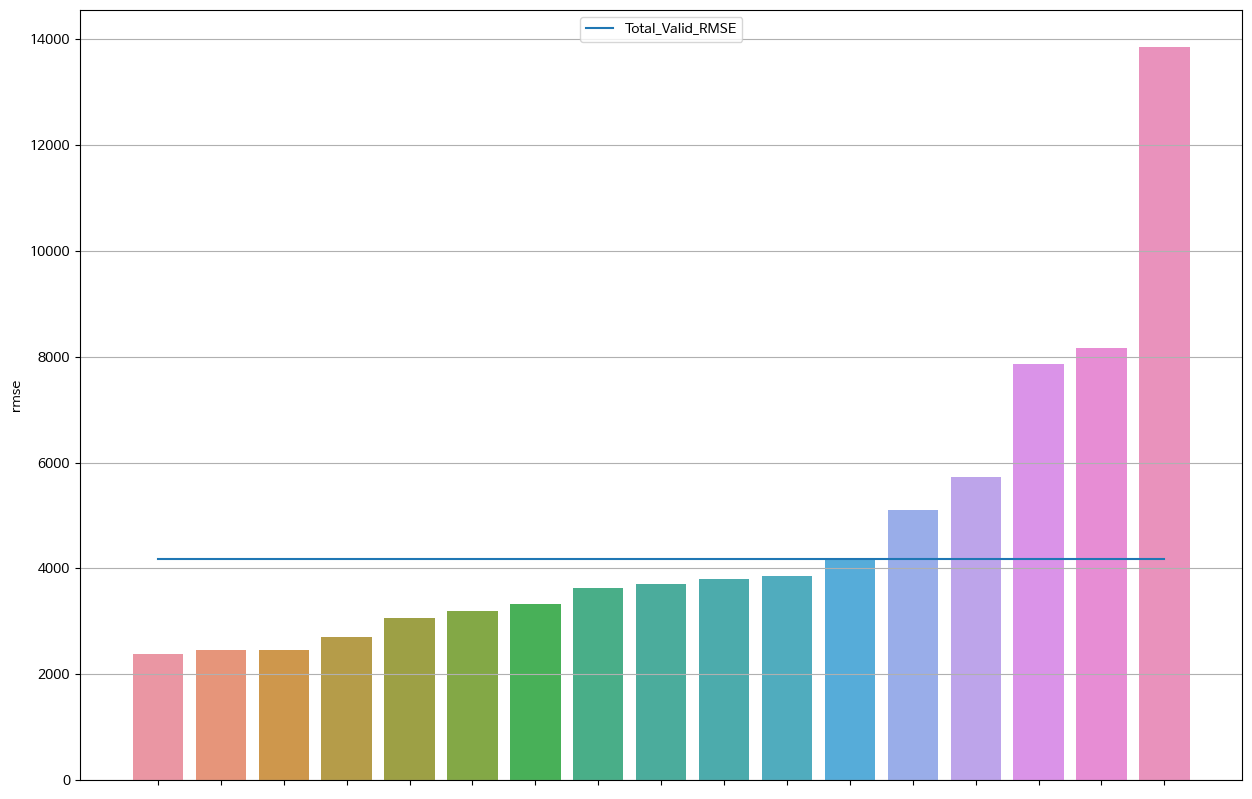

In [64]:
plt.figure(figsize=(15, 10))
barplot = sns.barplot(data=valid_rmse_df,
                      x='code',
                      y='rmse',
                      order=valid_rmse_df['code'])
barplot.set(xticklabels=[])
barplot.set(xlabel=None)
sns.lineplot(x=valid_rmse_df['code'].index, y=[RMSE] * len(valid_rmse_df), label="Total_Valid_RMSE")
plt.legend(loc='upper center')
plt.grid(True, axis='y')
plt.show()

In [142]:
# lgb.plot_tree(gbm_trained,
#               figsize=(50,20))

- 변수 중요도도 확인해보도록 하겠습니다.

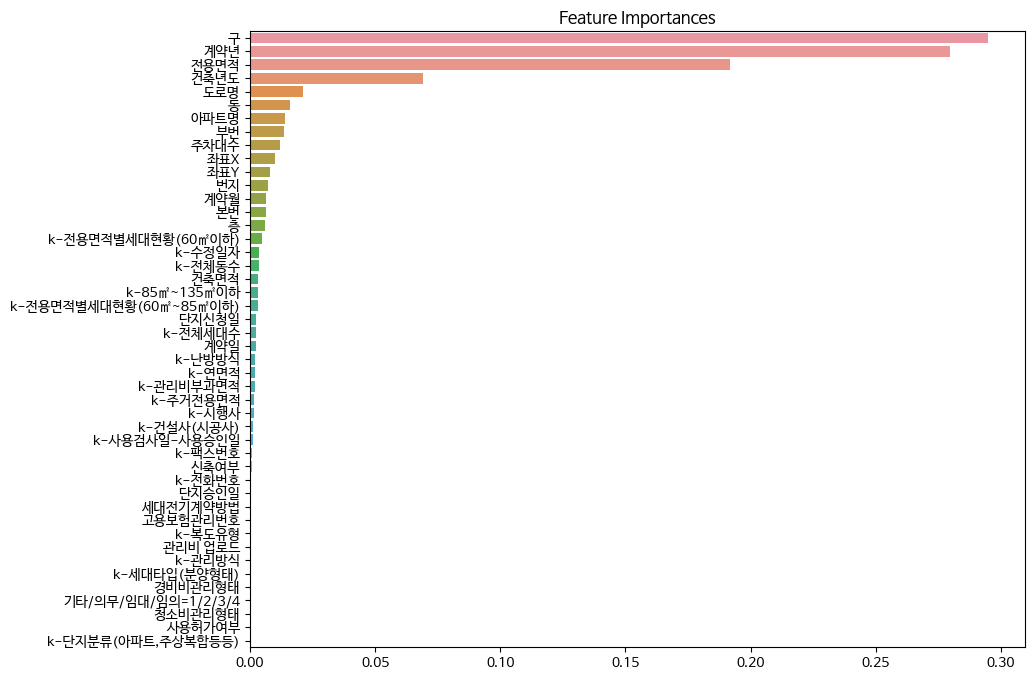

In [124]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [125]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### 5.3. Feature selection

- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [126]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
980355994.2798 ± 4175490.2752,구
885795419.3907 ± 6245203.5553,계약년
508433698.4283 ± 3360375.8595,전용면적
244149195.7572 ± 2581542.3123,건축년도
59523877.8859 ± 387021.0212,도로명
53750628.4683 ± 522719.0461,동
47878178.8412 ± 867357.2341,부번
46402428.7603 ± 213700.9380,아파트명
25642542.7111 ± 101773.8261,좌표X
21584273.9819 ± 183055.5460,좌표Y


- 분석 결과 "계약년", "전용면적" 변수가 유의한 변수로 보입니다. 따라서 이 변수로 또 다른 파생변수를 더 생성해보거나, 중요도가 낮아보이는 변수를 제거해 차원의 저주를 막아볼 수도 있습니다.

### 5.4. Valid prediction 분석

- 예측값을 분석해보기 위해 valid prediction을 확인해보겠습니다.

In [127]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [128]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [129]:
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [130]:
X_val_sort.head()

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",...,좌표Y,단지신청일,구,동,계약년,계약월,신축여부,target,pred,error
232753,4866,1223,0,2080,107.470,11,1,1973,5026,0,...,37.600846,249,24,111,15,0,0,287000.0,537200.0,6.260004e+10
240000,3626,953,14,200,79.470,17,9,1974,5248,0,...,37.495582,249,23,179,14,6,0,81500.0,260700.0,3.211264e+10
224608,4125,1074,258,4766,91.680,27,3,2017,2220,0,...,37.487309,249,23,281,15,5,1,117562.0,281500.0,2.687567e+10
423713,1094,413,0,3571,78.500,18,8,2018,6688,0,...,37.556097,249,24,256,12,1,1,109258.0,246400.0,1.880793e+10
201069,2055,660,1,3579,113.087,11,7,2014,5527,3,...,37.509505,79,23,45,16,1,1,281000.0,145400.0,1.838736e+10


- 예측을 잘 하지 못한 top 100개의 데이터와 예측을 잘한 top 100개의 데이터를 비교해보겠습니다.

In [131]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [132]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [133]:
display(error_top100.head(1))
display(best_top100.head(1))

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",...,좌표Y,단지신청일,구,동,계약년,계약월,신축여부,target,pred,error
232753,757,757.0,0.0,반포주공1단지,107.47,11,1,1973,신반포로 45,NULL,...,37.600846,NULL,97447.87659815107,반포동,2022,01,0,287000.0,537200.0,6.260004e+10


,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",...,좌표Y,단지신청일,구,동,계약년,계약월,신축여부,target,pred,error
1059197,1015,1015.0,0.0,길음뉴타운경남아너스빌,84.88,26,20,1999,정릉로 305,NULL,...,37.596653,NULL,44570.23969284212,정릉동,2008,01,0,33500.0,33500.0,0.0


- 이제 분포를 비교해보도록 하겠습니다.

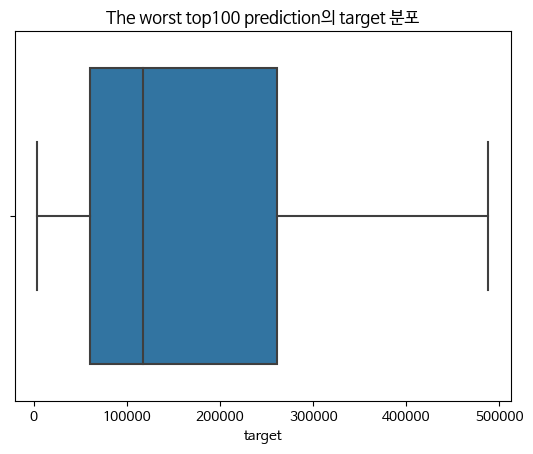

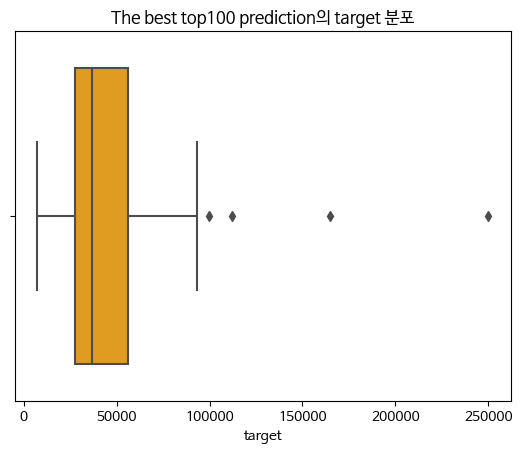

In [134]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

- Taget 분포를 보니 좋은 예측을 보인 top 100개의 data보다 상대적으로 나쁜 예측을 보인 top 100 dataset들이 높은 가격을 보였음을 확인할 수 있습니다. 이에 대한 모델링 및 처리가 필요해보입니다.

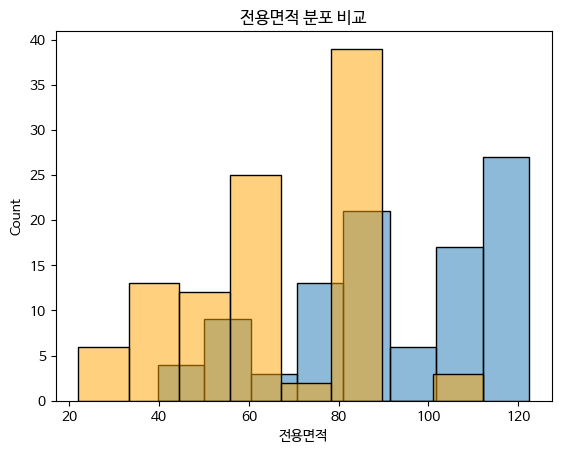

In [135]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

- 전용면적 또한 나쁜 예측을 보인 집들이 더 넓음을 확인할 수 있습니다.

## 6. Inference

In [59]:
dt_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,k_단지분류_아파트_주상복합등등_,...,관리비_업로드,좌표X,좌표Y,단지신청일,target,구,동,계약년,계약월,신축여부
0,4282,1114,1,293,79.9700,26,5,1987,5520,3,...,0,127.057210,37.476763,240,0,23,8,16,6,0
1,4258,1107,1,294,108.2017,15,10,2021,431,3,...,0,127.056394,37.484892,236,0,23,8,16,7,1


In [60]:
X_test = dt_test.drop(['target'], axis=1)

In [61]:
# model = joblib.load('tuning_lightgbm_sklearn_api.pkl')

In [62]:
# %%time
# X_test = dt_test.drop(['target'], axis=1)

# real_test_pred = model.predict(X_test)

In [63]:
# # 저장된 모델을 불러옵니다.
# with open('saved_model.pkl', 'rb') as f:
#     model = pickle.load(f)

In [64]:
# %%time
# X_test = dt_test.drop(['target'], axis=1)

# # Test dataset에 대한 inference를 진행합니다.
# real_test_pred = model.predict(X_test)

In [65]:
total_preds = []

for file_name in fold_save_files:
    model = joblib.load(file_name)
    test_pred = model.predict(X_test)
    total_preds.append(test_pred)

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


In [66]:
total_preds = np.array(total_preds)

real_test_pred = total_preds.mean(axis=0)

In [67]:
np.squeeze(real_test_pred)

array([191961.20853517, 282522.15346615, 247248.26371668, ...,
        80726.77133183,  67623.61482722,  69748.39462478])

In [68]:
real_test_pred 

array([191961.20853517, 282522.15346615, 247248.26371668, ...,
        80726.77133183,  67623.61482722,  69748.39462478])

## 7. Output File Save

In [69]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output_kfold.csv', index=False)